<a href="https://colab.research.google.com/github/YasirHabib/tensorflow/blob/master/fashion_mnist_th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [0]:
import theano.tensor as T
import theano

In [523]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df_train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/fashion-mnist_train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/fashion-mnist_test.csv')

In [0]:
def optimizer_update(cost, parameters, lr):
  grads = T.grad(cost, parameters)
  updates = []
  for p, g in zip(parameters, grads):
    update_p = p - lr*g
    
    updates.append((p, update_p))
    
  return updates

In [0]:
def optimizer_update_momentum(cost, parameters, lr, mu=0.9):
  grads = T.grad(cost, parameters)
  updates = []
  for p, g in zip(parameters, grads):
    # momentum
	  zeros = np.zeros_like(p.get_value(), dtype=np.float32)
	  m = theano.shared(zeros)
	  new_m = mu*m - lr*g

		# param update
	  update_p = p + new_m

		# append the updates
	  updates.append((p, update_p))
    
  return updates

In [0]:
def optimizer_update_rmsprop(cost, parameters, lr, decay_rate = 0.999, eps = 1e-10):
  grads = T.grad(cost, parameters)
  updates = []
  for p, g in zip(parameters, grads):
    # rmsprop
    ones = np.ones_like(p.get_value(), dtype=np.float32)
    c = theano.shared(ones)
    c = decay_rate*c + (1-decay_rate)*g*g
    update_p = p - lr*g / (np.sqrt(c) + eps)
    
    updates.append((p, update_p))
    
  return updates

In [0]:
def optimizer_update_adam(cost, parameters, lr, beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
  grads = T.grad(cost, parameters)
  updates = []
  t=1
  for p, g in zip(parameters, grads):
    # adam
    zeros_1 = np.zeros_like(p.get_value(), dtype=np.float32)
    m = theano.shared(zeros_1)
    new_m = beta1*m + (1-beta1)*g

    zeros_2 = np.zeros_like(p.get_value(), dtype=np.float32)
    v = theano.shared(zeros_2)
    new_v = beta2*v + (1-beta2)*g*g
    
    correction1 = 1-beta1 ** t
    hat_new_m = new_m / correction1
    
    correction2 = 1-beta2 ** t
    hat_new_v = new_v / correction2
    
    t += 1
    
    update_p = p - lr*hat_new_m / np.sqrt(hat_new_v + eps)
    
    updates.append((p, update_p))
    
  return updates

In [0]:
class HiddenLayers():
  def __init__(self, D, M):
    self.D = D
    self.M = M
    W = np.random.randn(D, M) / np.sqrt(D)
    b = np.random.randn(M)
    self.W = theano.shared(W)
    self.b = theano.shared(b)
    self.params = [self.W, self.b]
    
  def HiddenLayers_forward(self, X):
    return T.nnet.relu(X.dot(self.W)+self.b)

In [0]:
class FinalLayers():
  def __init__(self, M, K):
    self.M = M
    self.K = K
    W = np.random.randn(M, K) / np.sqrt(M)
    b = np.random.randn(K)
    self.W = theano.shared(W)
    self.b = theano.shared(b)
    self.params = [self.W, self.b]
    
  def FinalLayers_forward(self, Z):
    return T.nnet.softmax(Z.dot(self.W)+self.b)

In [0]:
class ANN():
  def __init__(self, size):
    self.size = size
    
  def fit(self, Xtrain, Ytrain, Xtest, Ytest, lr=10e-2, reg=0.01, training_epochs=10, batch_sz=500):
    Xtrain = Xtrain.astype(np.float32)
    Ytrain = Ytrain.astype(np.int32)
    
    Xtest = Xtest.astype(np.float32)
    Ytest = Ytest.astype(np.int32)
    
    N,D = Xtrain.shape
    K = len(set(Ytrain))
    
    self.layers=[]
    h = HiddenLayers(D,self.size)
    self.layers.append(h)
    
    f = FinalLayers(self.size,K)
    self.layers.append(f)
    
    self.parameters = []
    for obj in self.layers:                # first obj is h and second obj is f
      #self.parameters.append(obj.params)
      self.parameters += obj.params
    #print(self.parameters)                [<TensorType(float64, matrix)>, <TensorType(float64, vector)>, <TensorType(float64, matrix)>, <TensorType(float64, vector)>]
    
    X = T.fmatrix('X')
    Y = T.ivector('Y')
    pY = self.th_forward(X)
    
    rcost = reg*T.sum([(p*p).sum() for p in self.parameters])
    #for p in self.parameters:
      #print(p)                            <TensorType(float64, matrix)>
      #                                    <TensorType(float64, vector)>
      #                                    <TensorType(float64, matrix)>
      #                                    <TensorType(float64, vector)>
    cost = -T.mean(T.log(pY[T.arange(Y.shape[0]), Y])) + rcost
    
    #updates = optimizer_update(cost, self.parameters, lr)
    #updates = optimizer_update_momentum(cost, self.parameters, lr)
    updates = optimizer_update_rmsprop(cost, self.parameters, lr)
    #updates = optimizer_update_adam(cost, self.parameters, lr)
    
    train_op = theano.function(inputs=[X,Y], updates=updates)
    
    pred = self.th_forward(X)
    prediction = T.argmax(pred, axis=1)
    test_op = theano.function(inputs=[X,Y], outputs=[cost,prediction])
    
    n_batches = N // batch_sz
    costs = []
    
    for epoch in range(training_epochs):
      for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz)]
        Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz)]
        
        train_op(Xbatch, Ybatch)
        
        if j % 1 == 0:
          c, p = test_op(Xtest, Ytest)
          costs.append(c)
          e = np.mean(p != Ytest)
          print("Epoch", (epoch + 1), ": cost =", c, "error rate =", e)
          
    plt.plot(costs, label="cost")
    plt.show()
  
  def th_forward(self, X):
    for obj in self.layers[:-1]:           # this obj is h
      Z = obj.HiddenLayers_forward(X)
    for obj in self.layers[-1:]:           # this obj is f
      pY = obj.FinalLayers_forward(Z)
    return pY

In [0]:
def main():
  data_train = df_train.values
  data_test = df_test.values

  Xtrain = data_train[:,1:]
  Ytrain = data_train[:,0]

  Xtest = data_test[:,1:]
  Ytest = data_test[:,0]
  
  # Normalization
  Xtrain = (Xtrain - Xtrain.mean(axis=0)) / Xtrain.std(axis=0)
  Xtest = (Xtest - Xtest.mean(axis=0)) / Xtest.std(axis=0)
  
  model=ANN(128)
  model.fit(Xtrain, Ytrain, Xtest, Ytest)

Epoch 1 : cost = 4.463217600009256 error rate = 0.5982
Epoch 1 : cost = 4.054352994610363 error rate = 0.3838
Epoch 1 : cost = 3.891008018724276 error rate = 0.3408
Epoch 1 : cost = 3.793607264777662 error rate = 0.3201
Epoch 1 : cost = 3.7231313970782827 error rate = 0.3029
Epoch 1 : cost = 3.697528810503405 error rate = 0.3097
Epoch 1 : cost = 3.665781393581542 error rate = 0.3128
Epoch 1 : cost = 3.599931569158262 error rate = 0.2807
Epoch 1 : cost = 3.5919531773946454 error rate = 0.2983
Epoch 1 : cost = 3.5403632812797245 error rate = 0.2709
Epoch 1 : cost = 3.50141283910911 error rate = 0.2639
Epoch 1 : cost = 3.4678130766366997 error rate = 0.2542
Epoch 1 : cost = 3.441839698379871 error rate = 0.254
Epoch 1 : cost = 3.444264796821316 error rate = 0.2575
Epoch 1 : cost = 3.419005176871053 error rate = 0.2518
Epoch 1 : cost = 3.393136435339231 error rate = 0.2413
Epoch 1 : cost = 3.3636802235821284 error rate = 0.2353
Epoch 1 : cost = 3.3492300737344727 error rate = 0.238
Epoch 1

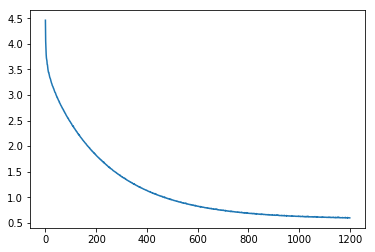

In [533]:
if __name__=='__main__':
  main()